# Phase 2: Modeling and Explainability

This notebook follows the exploratory data analysis (EDA) and focuses on modeling, evaluation, and interpretability. 
The main objectives are:

1. **Cluster-based profiling** of tourists according to trip characteristics and expenditure patterns.  
2. **Prediction of key variables** such as daily average expenditure and trip length.  
3. **Explainability using SHAP values**, to make the models transparent and suitable for reporting in the chatbot-based system.  

The prepared dataset (`egatur_data_ready.csv`) created in the EDA phase will be the starting point. 

Load all required libraries, including machine learning, visualization, and explainability tools. Also, load the processed dataset from the previous EDA phase.

In [1]:
# ===============================
# 1. Setup & Data Loading
# ===============================
import pandas as pd
import numpy as np
from pathlib import Path

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, classification_report
from sklearn.decomposition import PCA
import seaborn as sns
from adjustText import adjust_text
import matplotlib.pyplot as plt


# Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.neural_network import MLPClassifier


# Explainability
import shap
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay

# Saving
import joblib

# Paths
DATA_DIR = Path("../data/processed")
df = pd.read_csv(DATA_DIR / "egatur_data_ready.csv")

df.head()

,daily_average_expenditure,trip_length,accommodation,purpose,season,country,region,cluster
0,129.318995,14,Non-market,Leisure/holidays,winter,Occident and America,Valencian Community,0
1,127.224771,16,Non-market,Leisure/holidays,winter,Occident and America,Valencian Community,0
2,273.413983,9,Hotels and similar,Leisure/holidays,winter,Occident and America,Madrid,3
3,111.493501,27,Non-market,Leisure/holidays,winter,Occident and America,Valencian Community,0
4,124.846663,14,Non-market,Other,winter,Occident and America,Canary Islands,2


## Data Preparation

The dataset contains both numerical and categorical variables.  
For modeling purposes, we will:
- Scale numerical variables (`daily_average_expenditure_log`, `trip_length_log`).
- Encode categorical variables (`accommodation`, `purpose`, `season`, `country`, `region`).
- Separate target variables for supervised models.

Define feature columns (inputs) and target columns (outputs) for regression and clustering models.

In [2]:
# Features and targets
features = ["accommodation", "purpose", "season", "country", "region",
            "daily_average_expenditure", "trip_length"]

target_expenditure = "daily_average_expenditure"
target_trip_length = "trip_length"

X = df[features]
y_expenditure = df[target_expenditure]
y_trip_length = df[target_trip_length]

# Preprocessing pipeline
numeric_features = ["daily_average_expenditure", "trip_length"]
categorical_features = ["accommodation", "purpose", "season", "country", "region"]

# Transformer: log(1+x) to avoid log(0)
log_transformer = FunctionTransformer(np.log1p, validate=False)

numeric_pipeline = Pipeline(steps=[
    ("log", log_transformer),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ("onehot", OneHotEncoder(drop="first", handle_unknown="ignore",
                             categories=[df[col].unique() for col in categorical_features])),
    ("scaler", StandardScaler(with_mean=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipeline, numeric_features),
        ("cat", categorical_pipeline, categorical_features)
    ]
)

We have built two pipelines for numeric and categorical variables to ensure consistent preprocessing:

- Numeric: log transformation + standard scaling  
- Categorical: one-hot encoding + scaling (to normalize magnitudes for algorithms sensitive to feature scale)  

## Clustering with classificator

We want a reproducible model that predicts the same clusters obtained in the EDA.
By training a neural network to replicate the original cluster labels, we can apply
it to new data while keeping the same segmentation logic.

In [3]:
# Features and target
X_clusters = df[features]
y_clusters = df["cluster"]  # clusters from the original EDA

# Train/test split (stratified to preserve cluster proportions)
X_train, X_test, y_train, y_test = train_test_split(
    X_clusters, y_clusters, test_size=0.2, random_state=42, stratify=y_clusters
)

In [4]:
# Neural network classifier pipeline
nn_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),  # same preprocessing as clustering pipeline
    ("classifier", MLPClassifier(
        hidden_layer_sizes=(100,50),
        activation="relu",
        solver="adam",
        max_iter=500,
        random_state=42
    ))
])

# Train the neural network
nn_pipeline.fit(X_train, y_train)

# Predict on test set
y_pred = nn_pipeline.predict(X_test)

# Evaluate performance
print("Classification report for EDA clusters (Neural Network):")
print(classification_report(y_test, y_pred))

# Apply to full dataset to generate reproducible cluster labels
df["cluster_pred_nn"] = nn_pipeline.predict(X_clusters)

# Save the neural network classifier
joblib.dump(nn_pipeline, "../models/cluster/cluster_classifier_eda_nn.joblib")

# Quick summary of predicted clusters
print("\nCluster counts (supervised NN prediction):")
print(df["cluster_pred_nn"].value_counts())

Classification report for EDA clusters (Neural Network):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6426
           1       1.00      1.00      1.00     20672
           2       1.00      1.00      1.00      6909
           3       1.00      1.00      1.00     13151

    accuracy                           1.00     47158
   macro avg       1.00      1.00      1.00     47158
weighted avg       1.00      1.00      1.00     47158


Cluster counts (supervised NN prediction):
cluster_pred_nn
1    103573
3     65538
2     34560
0     32117
Name: count, dtype: int64


In [5]:
nn_pipeline = joblib.load("../models/cluster/cluster_classifier_eda_nn.joblib")

The neural network achieves an almost perfect accuracy when reproducing the EDA clusters.  
This is expected because the `labels` (clusters) come from a deterministic algorithm (KMeans) and are fully separable given the preprocessing.  
Therefore, the network is not discovering new patterns but rather **learning to replicate the segmentation logic** established during the EDA.  
This ensures consistency: when applying the model to new data, the cluster assignment will be aligned with the original exploratory segmentation.

In [6]:
# We define the stratified CV (to preserve the proportion of clusters)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluation with accuracy
cv_scores = cross_val_score(nn_pipeline, X_clusters, y_clusters, cv=cv, scoring="accuracy", n_jobs=4)

print("Cross-validation accuracy scores:", cv_scores)
print("Mean CV accuracy:", cv_scores.mean())


Cross-validation accuracy scores: [0.99817634 0.99830358 0.99830358 0.9988973  0.99832475]
Mean CV accuracy: 0.9984011078588807


To confirm the robustness of the model, we applied a 5-fold stratified cross-validation.  
The results show accuracies consistently above 99.8%, confirming that the clusters are **stable and easy to reproduce** across different data splits.  
This reinforces that the neural network generalizes the cluster structure rather than simply memorizing the training set.

In summary, the neural network classifier serves as a **reproducible mapping** from raw trip features to the EDA-defined clusters.  
This allows us to:  
- Preserve the interpretability of the original segmentation.  
- Ensure new incoming data can be assigned to the same clusters.  
- Integrate this logic into downstream tasks (e.g., supervised modeling, chatbot explanations).  

The near-perfect accuracy should not be interpreted as overfitting, but as a confirmation that the EDA segmentation is fully recoverable given the available features.

To reduce the latency of the multi-agent system, it was decided to replace the neural network with a simpler model (logistic regression), since the results were virtually identical and the additional complexity was not justified. This decision enables faster responses without sacrificing accuracy in cluster assignment.

In [7]:
from sklearn.linear_model import LogisticRegression

# ===========================
# Logistic Regression
# ===========================
logreg_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(
        multi_class="multinomial",
        solver="lbfgs",
        max_iter=1000,
        random_state=42
    ))
])

logreg_pipeline.fit(X_train, y_train)
y_pred_logreg = logreg_pipeline.predict(X_test)

print("Classification report (Logistic Regression):")
print(classification_report(y_test, y_pred_logreg))

Classification report (Logistic Regression):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6426
           1       1.00      1.00      1.00     20672
           2       1.00      1.00      1.00      6909
           3       1.00      1.00      1.00     13151

    accuracy                           1.00     47158
   macro avg       1.00      1.00      1.00     47158
weighted avg       1.00      1.00      1.00     47158



In [8]:
# We define the stratified CV (to preserve the proportion of clusters)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluation with accuracy
cv_scores = cross_val_score(logreg_pipeline, X_clusters, y_clusters, cv=cv, scoring="accuracy", n_jobs=4)

print("Cross-validation accuracy scores:", cv_scores)
print("Mean CV accuracy:", cv_scores.mean())

Cross-validation accuracy scores: [0.99777344 0.99845201 0.99813393 0.99826113 0.99834595]
Mean CV accuracy: 0.9981932932146338


In [9]:
# Save the logistic regression classifier
joblib.dump(logreg_pipeline, "../models/cluster/cluster_classifier_eda_lr.joblib")

['../models/cluster/cluster_classifier_eda_lr.joblib']

In [10]:
logreg_pipeline = joblib.load("../models/cluster/cluster_classifier_eda_lr.joblib")

## Supervised Regression Model

After exploring several modeling options, we focus on a single supervised regression task: predicting **average daily expenditure** using all available trip features. This approach is most relevant for our application, as it enables us to classify and profile tourists by their spending behavior—an essential insight for downstream reporting and chatbot explanations.

In [11]:
# Define target
target_col = "daily_average_expenditure"

y = df[target_col]
X = df[[f for f in features if f != target_col]]

cat_cols = [col for col in X.columns if col in categorical_features]
num_cols = [col for col in X.columns if col in numeric_features]

# Preprocesador
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
    ("num", StandardScaler(), num_cols)
])

We try out a few different models to predict daily average expenditure:

- Linear Regression as a simple baseline  
- Random Forest for flexible, non-linear relationships  
- Gradient Boosting for stronger ensemble performance  
- HistGradientBoosting for fast and efficient boosting  

We use cross-validation with R2, MAE, and RMSE to get a fair comparison of how each model performs.

In [12]:
# Models to evaluate (baseline configs)
models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    "GradientBoosting": GradientBoostingRegressor(random_state=42, n_estimators=100),
    "HistGradientBoosting": HistGradientBoostingRegressor(random_state=42)
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)
results = []

for model_name, model in models.items():
    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("regressor", model)
    ])
    scores = cross_validate(
        pipe, X, y,
        cv=cv,
        scoring=["r2", "neg_mean_absolute_error", "neg_root_mean_squared_error"],
        return_train_score=False,
        n_jobs=4
    )
    results.append({
        "model": model_name,
        "R2_mean": np.mean(scores["test_r2"]),
        "MAE_mean": -np.mean(scores["test_neg_mean_absolute_error"]),
        "RMSE_mean": -np.mean(scores["test_neg_root_mean_squared_error"])
    })

results_df = pd.DataFrame(results)
results_df

,model,R2_mean,MAE_mean,RMSE_mean
0,LinearRegression,0.410654,75.139150,155.240273
1,RandomForest,0.659895,49.298094,117.919709
2,GradientBoosting,0.666203,49.127912,116.829239
3,HistGradientBoosting,0.672925,48.292829,115.644059


As it is not the main problem we want to explore, we pick the best model (HistGradientBoosting) and fine-tune its hyperparameters with `GridSearchCV` to squeeze out extra performance without changing the overall model type.

In [13]:
pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", HistGradientBoostingRegressor(random_state=42))
])

param_grid = {
    "regressor__learning_rate": [0.01, 0.05, 0.1],
    "regressor__max_iter": [100, 200, 500],
    "regressor__max_depth": [None, 5, 10],
    "regressor__min_samples_leaf": [20, 50, 100],
    "regressor__l2_regularization": [0.0, 0.1, 1.0]
}

grid = GridSearchCV(
    pipe,
    param_grid,
    cv=5,
    scoring="r2",
    n_jobs=-1,
    verbose=2
)

grid.fit(X, y)

print("Mejores parámetros:", grid.best_params_)
print("Mejor R2 CV:", grid.best_score_)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[CV] END regressor__l2_regularization=0.0, regressor__learning_rate=0.01, regressor__max_depth=None, regressor__max_iter=100, regressor__min_samples_leaf=20; total time=   9.8s
[CV] END regressor__l2_regularization=0.0, regressor__learning_rate=0.01, regressor__max_depth=None, regressor__max_iter=100, regressor__min_samples_leaf=20; total time=  10.9s
[CV] END regressor__l2_regularization=0.0, regressor__learning_rate=0.01, regressor__max_depth=None, regressor__max_iter=100, regressor__min_samples_leaf=20; total time=  10.8s
[CV] END regressor__l2_regularization=0.0, regressor__learning_rate=0.01, regressor__max_depth=None, regressor__max_iter=100, regressor__min_samples_leaf=20; total time=   9.4s
[CV] END regressor__l2_regularization=0.0, regressor__learning_rate=0.01, regressor__max_depth=None, regressor__max_iter=100, regressor__min_samples_leaf=20; total time=   8.8s
[CV] END regressor__l2_regularization=0.0, regresso

In [14]:
# Get the best model
best_model = grid.best_estimator_

# Save 
joblib.dump(best_model, "../models/daily_avg_exp/histgradientboosting_model.joblib")

['../models/daily_avg_exp/histgradientboosting_model.joblib']

In [15]:
best_model = joblib.load("../models/daily_avg_exp/histgradientboosting_model.joblib")

In [16]:
scores = cross_validate(
    best_model,
    X, y,
    cv=5,
    scoring=["r2", "neg_mean_absolute_error", "neg_root_mean_squared_error"],
    return_train_score=False,
    n_jobs=-1
)

tuned_results = {
    "model": "HistGradientBoosting (tuned)",
    "R2_mean": np.mean(scores["test_r2"]),
    "MAE_mean": -np.mean(scores["test_neg_mean_absolute_error"]),
    "RMSE_mean": -np.mean(scores["test_neg_root_mean_squared_error"])
}

results_df = pd.concat([results_df, pd.DataFrame([tuned_results])], ignore_index=True)

results_df

,model,R2_mean,MAE_mean,RMSE_mean
0,LinearRegression,0.410654,75.139150,155.240273
1,RandomForest,0.659895,49.298094,117.919709
2,GradientBoosting,0.666203,49.127912,116.829239
3,HistGradientBoosting,0.672925,48.292829,115.644059
4,HistGradientBoosting (tuned),0.673479,48.355998,115.521238


Despite hyperparameter tuning, the final model only improved slightly over the baseline HistGradientBoosting, indicating that further gains may require additional features or alternative modeling strategies.

## Explainability

Now that we’ve got our best model trained, it’s time to peek inside and see **how it actually makes predictions**.  
We’ll do this using three different (but complementary) tools:

- **Permutation Feature Importance (PFI):** tells us which features the model relies on the most.  
- **Partial Dependence Plots (PDP):** show the shape of the relationship between a feature and the prediction.  
- **SHAP values:** let us break down each prediction into contributions from each feature (both globally and for individual tourists).  

These will help us understand not just *what* the model predicts, but also *why*.  

In [17]:
# Extract the trained regressor from the pipeline
reg = best_model.named_steps["regressor"]
preproc = best_model.named_steps["preprocessor"]
feature_names=preproc.get_feature_names_out()
X_transformed = preproc.transform(X)
X_transformed = np.array(X_transformed, copy=True)

### PFI

PFI measures how much the model depends on each feature by shuffling them one at a time and checking how much performance drops.  

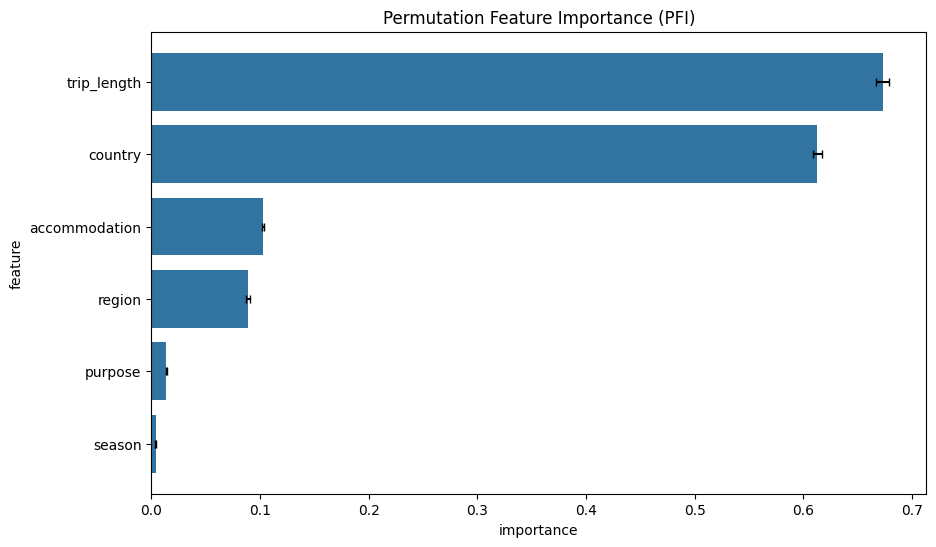

In [18]:
# Permutation Feature Importance
result = permutation_importance(
    best_model, X, y, n_repeats=10, random_state=42
)

pfi = pd.DataFrame({
    "feature": X.columns,
    "importance": result.importances_mean,
    "std": result.importances_std
}).sort_values("importance", ascending=False)

# Plot PFI
plt.figure(figsize=(10,6))
sns.barplot(
    data=pfi.head(15),
    x="importance",
    y="feature"
)

# Add errors
plt.errorbar(
    x=pfi.head(15)["importance"],
    y=np.arange(len(pfi.head(15))),
    xerr=pfi.head(15)["std"].values,
    fmt="none",
    c="black",
    capsize=3
)
plt.title("Permutation Feature Importance (PFI)")
plt.show()

Here’s what we see:  

- **Trip length** dominates, with an importance score close to **0.7**.  
- **Country of origin** also plays a huge role (above **0.6**).  
- **Accommodation** and **region** matter a bit (just above **0.1**).  
- **Purpose** and **season**? Basically irrelevant for predicting daily spend.  

So, the two big drivers are: **how long the trip is** and **where the tourist is from**. 

### PDP

PDPs show us **how** the features affect predictions.  

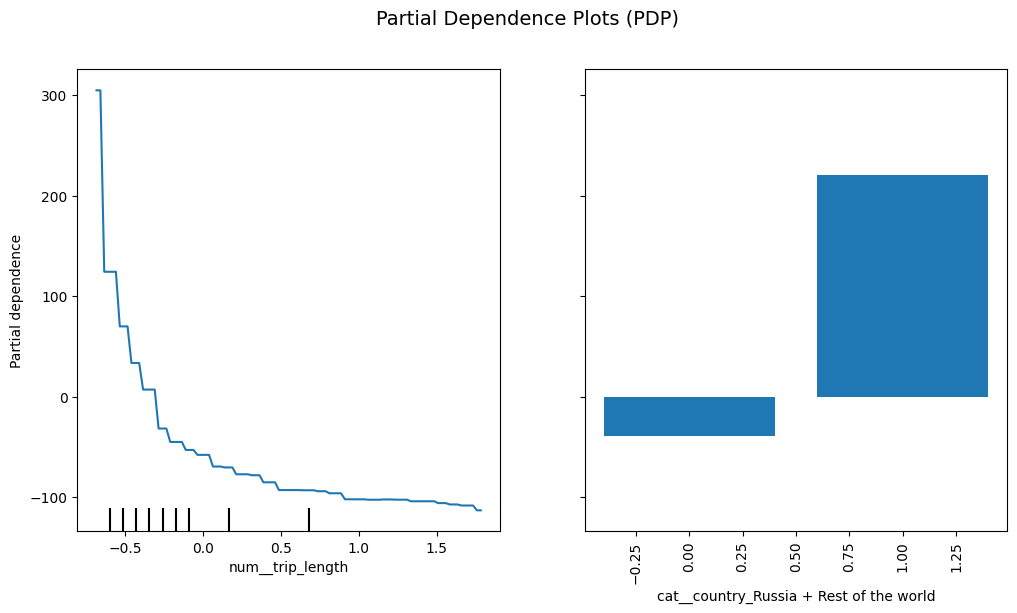

In [19]:
features_to_plot = [
    "num__trip_length",
    "cat__country_Russia + Rest of the world"
]

fig, ax = plt.subplots(figsize=(12, 6))
PartialDependenceDisplay.from_estimator(
    reg, X_transformed, features_to_plot, feature_names=feature_names, ax=ax,
    categorical_features=["cat__country_Russia + Rest of the world"]
)
plt.suptitle("Partial Dependence Plots (PDP)", fontsize=14)
plt.show()

1. **Trip length (`num__trip_length`):**  
   - It behaves like a **negative exponential curve**.  
   - Very short trips → add up to **+€300 per day**.  
   - As the trip gets longer → spending quickly drops, stabilizing around **-€100**.  

   Makes sense: we have already seen this in the EDA, short visits tend to be intense (spend a lot per day), long visits spread the budget thinner.  

2. **Country (`cat__country_Russia + Rest of the world`):**  
   - Tourists from Russia/Rest of the world → spend **+€200 per day**.  
   - Everyone else → slightly below average (around -€20).  

### SHAP

SHAP values are like splitting the bill of a prediction fairly between features.  
Each feature gets a “share” of credit (or blame) for pushing the prediction up or down.  

- **Globally:** we can see which features matter most overall.  
- **Locally:** we can zoom into one specific tourist and see exactly why the model predicted what it did.  

Think of it this way: if the base value (the average prediction) is ~€234, SHAP tells us *how much each feature pushes that number up or down* for a given tourist. Let's see this next with the force plots.

In [20]:
# sample_X = X.sample(50000, random_state=42)
sample_X = X.copy()

Since we are using TreeExplainer (optimized for tree-based models), we can efficiently compute SHAP values for all observations in the dataset.

In [21]:
# Extract the trained regressor from the pipeline
reg = best_model.named_steps["regressor"]
preproc = best_model.named_steps["preprocessor"]

# Transform the sampled data
X_transformed = preproc.transform(sample_X)

# Use TreeExplainer (fast)
explainer = shap.TreeExplainer(reg)
shap_values = explainer(X_transformed)

In [22]:
# Pack everything
model_data = {
    "model": reg,
    "preprocessor": preproc,
    "explainer": explainer,
}

# Save model with preprocessor and explainer
joblib.dump(model_data, "../models/daily_avg_exp/expenditure_model.pkl")

['../models/daily_avg_exp/expenditure_model.pkl']

#### Force plots (local view)
Force plots visualize how each feature contributes to a single prediction, showing which variables push the prediction higher or lower compared to the average. This helps us interpret individual model decisions in a transparent, intuitive way.

Let’s look at a few examples:  

In [23]:
# Force plot for a single observation
idx = 10  # index of the observation to explain
shap.initjs()
shap.force_plot(
    explainer.expected_value,
    shap_values.values[idx,:],
    X_transformed[idx,:],
    feature_names=feature_names
)

- **Tourist 10 (prediction = €52 vs base €233.9):**  
For this tourist, the model predicts a daily average expenditure of €52, much lower than the base value of €233.9 (the average prediction if the model had no information). This large drop—about €180 below average—is mainly explained by a very long trip length, which strongly reduces the predicted spend (almost -€100). Additional negative contributions come from not staying in hotels and not being Russian, both of which further decrease the prediction. The SHAP force plot visualizes these effects as "forces" pulling the prediction down, showing how each feature contributes to the final result.

In [24]:
idx = 2
shap.initjs()
shap.force_plot(
    explainer.expected_value,
    shap_values.values[idx,:],
    X_transformed[idx,:],
    feature_names=feature_names
)

- **Tourist 2:**  
Here, the pushes are more balanced — some features increase, others decrease.  

One thing to highlight is that SHAP lets us interpret complex models almost as if they were linear regressions: we can see how much each variable contributes to the prediction, even though the underlying model is not linear. This bridges the gap between model accuracy and interpretability.

In [25]:
idx = 235785
shap.initjs()
shap.force_plot(
    explainer.expected_value,
    shap_values.values[idx,:],
    X_transformed[idx,:],
    feature_names=feature_names
)

- **Tourist 235785:**  
  - A high spender, mainly because of being Russian/Rest of the world.  
  - This feature alone explains a big upward shift in predicted spending.  

The following cell is used to obtain an example that will be included in the master's thesis report (TFM).

In [26]:
# Filter the dataset for Russian tourists with given conditions
mask = (
    (sample_X["country"] == "Russia + Rest of the world") &
    (sample_X["trip_length"] == 5) &
    (sample_X["purpose"] == "Leisure/holidays") &
    (sample_X["region"] == "Andalusia") &
    (sample_X["season"] == "spring") &
    (sample_X["accommodation"] == "Hotels and similar")
)

# Get the subset of rows
russian_tourists = sample_X[mask]
indexes = russian_tourists.index

# Compute the mean of the true values
true_mean = y.loc[indexes].mean()
print("Mean of true target values:", true_mean)

# Step: transform and predict only the first row
X_selected = preproc.transform(russian_tourists.loc[[indexes[0]]])
pred = reg.predict(X_selected)
print("Prediction:", pred)

# Generate SHAP force plot for that row
idx = indexes[0]  # first index that matches the filter
shap_value_single = shap_values.values[idx, :]
X_single = X_transformed[idx, :]

# Create force plot
shap.initjs()
shap.force_plot(
    explainer.expected_value,
    shap_values.values[idx,:],
    X_transformed[idx,:],
    feature_names=feature_names
)

Mean of true target values: 351.73372050868085
Prediction: [409.42865788]


#### SHAP summary plot (global view)

The SHAP summary plot combines feature importance with the direction and magnitude of each feature’s effect on the model’s predictions. Each point represents a tourist, colored by the feature value, showing both how much and in which direction each variable influences daily expenditure.

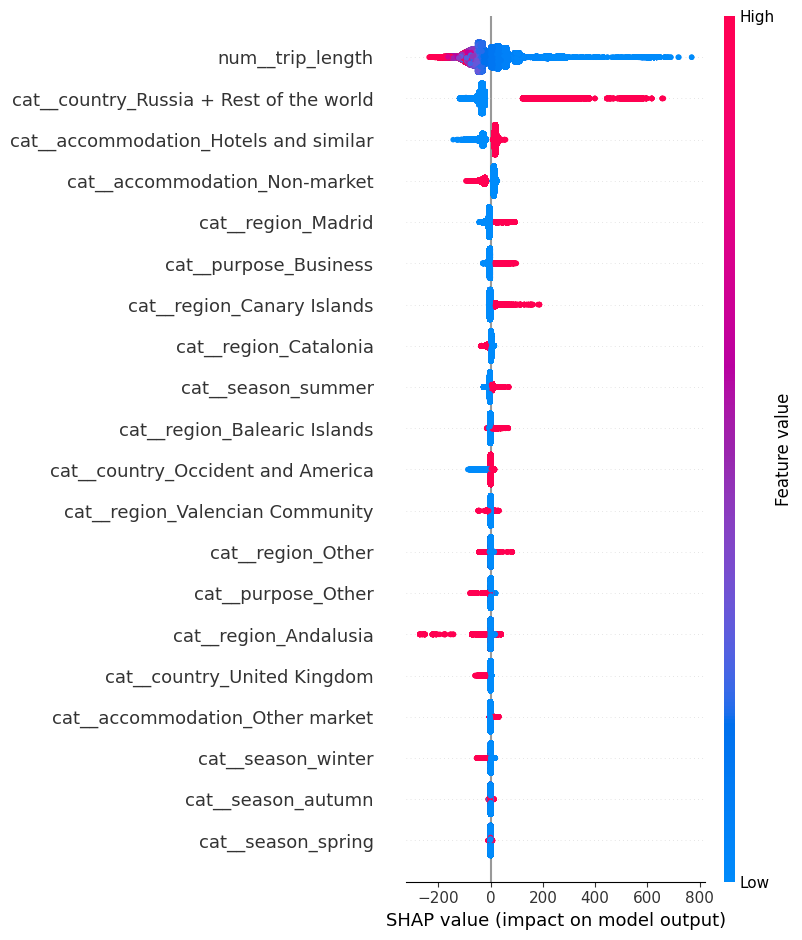

In [27]:
# Summary plot
shap.summary_plot(shap_values, X_transformed, feature_names=preproc.get_feature_names_out())

When we look across *all* tourists, the summary plot confirms the story:  

- **Trip length** is the top driver. Short trips → higher daily spend, long trips → lower.  
- **Country of origin** also consistently shifts predictions.  

The color coding shows the feature values (e.g., blue = short trips, red = long trips), which helps us see not just importance, but also direction.  

#### SHAP dependence plots

Dependence plots take it a step further:  

- For **trip length**, we again see the exponential drop-off. But SHAP also shows how this effect changes depending on nationality — Russians/Rest of the world consistently get a higher SHAP boost.  
- For **country**, the effect is pretty clear: being in that group adds anywhere from €200 to €700 depending on other features.  

This is richer than PDPs, because SHAP automatically highlights interactions.  

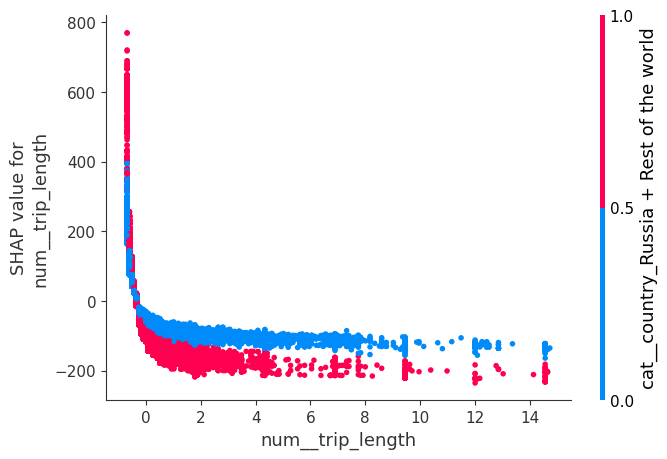

In [28]:
shap.dependence_plot("num__trip_length", shap_values.values, X_transformed, feature_names=preproc.get_feature_names_out())

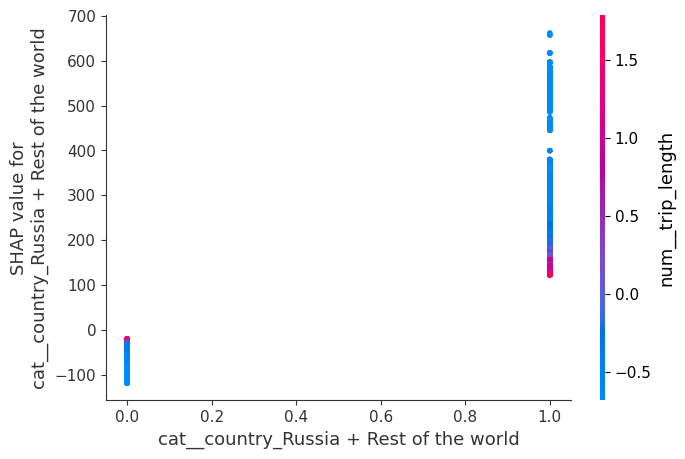

In [29]:
shap.dependence_plot("cat__country_Russia + Rest of the world", shap_values.values, X_transformed, feature_names=preproc.get_feature_names_out())

Finally, we have gained a sense of how our model makes predictions. Since the goal of this thesis is neither to build the best possible models nor to delve deeply into interpretability, the focus remains on providing actionable insights and reproducible logic for our chatbot, rather than exhaustive model optimization or explanation.

# Phase 2 Final Report – Modeling & Explainability

**Objectives:**  
1. Reproduce tourist segmentation defined in the EDA.  
2. Predict daily average expenditure.  
3. Provide transparent model explanations (SHAP, PFI, PDP).  

**Key Results:**  
- **Clusters:** A neural network replicates EDA clusters with >99.8% accuracy, ensuring consistent assignment for new tourists.  
- **Regression (daily expenditure):** **HistGradientBoosting** was the best model; hyperparameter tuning provided only slight improvement.  
- **Top predictors:**  
  - **Trip length** → primary driver (short trips = higher daily spend).  
  - **Country of origin** → strong influence (Russia / “Rest of world” = +€200/day).  
  - **Accommodation & region** → minor influence; purpose and season negligible.  
- **Explainability:** SHAP values confirm these patterns globally and for individual tourists.  

**Conclusion:**  
We now have:  
- A reproducible cluster classifier.  
- A robust predictive model for daily expenditure.  
- Clear interpretability tools for insights.  

These elements will feed into the **MCP report server**, 
where the chatbot can generate dynamic reports for end-users.